# Lab 2 - Clustering
In this lab we look at clustering with k-means and GMMs. We will work on putting together the skeleton code to create the functionality of the algorithms, and then we will cluster the Fisher Iris dataset. We will finish by looking at the sklearn implementations of these algorithms.

## Task 2.1 - Data Exploration
This task will load the data and explore the feature space of the observations. We will plot two feature dimensions against eachother, labeling them based on colour from the known class IDs.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

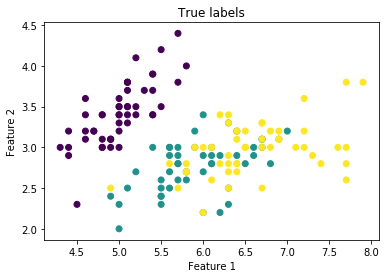

In [2]:
data = np.load('./LabClass-1/Iris_data.npy')
labels = np.load('./LabClass-1/Iris_labels.npy')

plt.scatter(data[:, 0], data[:, 1], c=labels)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('True labels')
plt.show()

## Task 2.2 - K-means Clustering 

### K-Means algorithm:

Setup: Select random initial set of k cluster centers

Loop:

    for i = 1 to maximum number of iterations

        calculate distance from training points to cluster centroids
    
        update class labels
    
        recalculate centroid locations

In [3]:
def euclidean_distance(k_centroids, datapoints):
    dists = np.zeros(shape=[datapoints.shape[0], k_centroids.shape[0]])
    
    for iK in range(0, k_centroids.shape[0]):
        centre = np.tile(k_centroids[iK, :], (datapoints.shape[0], 1))
        diff = centre - datapoints
        sum_of_squared_differences = np.zeros([datapoints.shape[0]])
        for i_dimension in range(0, k_centroids.shape[1]):
            sum_of_squared_differences += (diff[:, i_dimension]**2)
        dists[:,iK] = np.sqrt(sum_of_squared_differences)
    
    return dists

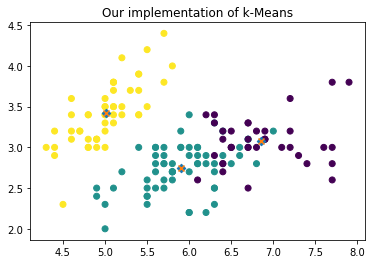

In [4]:
k = 3
n_iteration = 100

k_centroid = data[np.random.choice(data.shape[0], k), :]

for i in range(0, n_iteration):
    last_k_centroid = k_centroid
    
    #Calculate distances
    dists = euclidean_distance(k_centroid, data)
        
    #Reassign labels
    predicted_label = np.argmin(dists, axis=1)
    
    #Recalculate centroids
    new_centroid = np.zeros(shape=[k,data.shape[1]])
    for iK in range(0, k):
        #Get all allocated datapoints
        cluster_data = data[predicted_label == iK, :]
        #Calculate the mean of this cluster
        new_centroid[iK, :] = np.mean(cluster_data, axis=0)
        
    #Assign the new cluster centers
    k_centroid = new_centroid
        
    print('Iteration {0}: total update distance of centroids: {1}'.format(i, np.sum(np.abs(new_centroid - last_k_centroid))), end='\r')
    
#Visualisation of algorithm progress
plt.scatter(data[:, 0], data[:, 1], c=predicted_label)
plt.scatter(last_k_centroid[:, 0], last_k_centroid[:, 1], marker='D')
plt.scatter(k_centroid[:, 0], k_centroid[:, 1], marker='x')
plt.title('Our implementation of k-Means')
plt.show()

## Task 2.3 - Gaussian Mixture Models
### GMM Algorithm:
Setup: Randomly initialise Gaussian distribution centroid and standard deviations

Loop: 

    

In [5]:
#E step
def multivariate_gaussian_density(x, mu, sig):
    size = x.shape[0]
    det = np.linalg.det(sig)
    norm_const = 1.0 / ((2*np.pi)**(size/2) * det **(1.0/2) )
    x_mu = x - mu
    inv = np.linalg.inv(sig)  
    result = np.e**(-(1.0/2) * (x_mu @ inv @ x_mu.T))
    
    return norm_const * result
    
def likelihood(x,gCentroids, gSD, gMix):
    p = np.zeros([x.shape[0],gCentroids.shape[0]])
    p_total = np.zeros(x.shape[0])
    posteriors = np.zeros([x.shape[0],gCentroids.shape[0]])
    
    for iSample in range(0, x.shape[0]):
        for iCluster in range(0, gCentroids.shape[0]):
            p[iSample,iCluster] = multivariate_gaussian_density(x[iSample,:].T, gCentroids[iCluster,:], gSD[:,:,iCluster])
            p_total[iSample] = p_total[iSample] + p[iSample,iCluster] 
        
        for iCluster in range(0, gCentroids.shape[0]):
            posteriors[iSample, iCluster] = p[iSample, iCluster] / p_total[iSample]
            
    return posteriors    

#M step
def update_params(data, posteriors, gMix, gSD, gCentroids):
    #Update mixing coefs
    clusterWeight = np.sum(posteriors,axis=0)
    newGMix = (1/posteriors.shape[0]) * clusterWeight
    
    #Update centroids
    newCentroids = np.zeros(gCentroids.shape)
    for iCluster in range(0, gMix.shape[0]):
        norm = np.expand_dims(posteriors[:, iCluster],axis=1)/np.sum(posteriors[:,iCluster])
        newCentroids[iCluster, :] = np.sum(norm * data, axis=0)

    #Update covariance matrices
    newGSD = np.zeros(gSD.shape)
    for c in range(0, gMix.shape[0]):
        running_sum = np.zeros(gSD.shape[0:2]) 
        for iData in range(0, data.shape[0]):
            mean_centred_data = (np.expand_dims(data[iData, :],axis=0) - newCentroids[c,:])
            running_sum += posteriors[iData, iCluster] * mean_centred_data * mean_centred_data.T
        running_sum = running_sum / np.sum(posteriors[:,iCluster],axis=0)
        newGSD[:,:,c] = running_sum

    return newGMix, newGSD, newCentroids

### Initialise parameters
Initialise the number of components, the number of iterations and the Gaussian parameters (mus, sigmas, mixings).

In [6]:
g = 3
nIteration = 100

cluster_centroids = np.zeros([g,data.shape[1]])
g_SD = np.zeros([data.shape[1],data.shape[1], g])
g_mix = np.zeros(g)

for iCluster in range(0,g):
    data_in_cluster = data[predicted_label == iCluster, :]
    cluster_centroids[iCluster,:] = np.mean(data_in_cluster, axis=0)
    g_SD[:,:,iCluster] = np.cov(data_in_cluster.T)
    g_mix[iCluster] = data_in_cluster.shape[0] / data.shape[0]

### Main loop of GMM fitting
Loop over our iterations, computing steps E and M repeatedly.

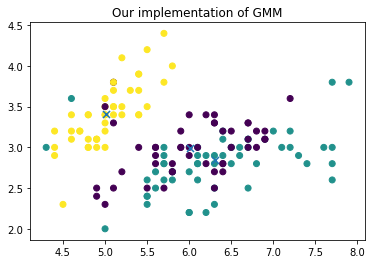

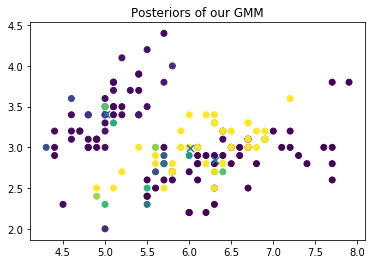

In [7]:
for i in range(0, nIteration):
    #E Step
    posteriors = likelihood(data, cluster_centroids, g_SD, g_mix)

    #M Step
    g_mix, g_SD, cluster_centroids = update_params(data, posteriors, g_mix, g_SD, cluster_centroids)
    print('Iteration {0}'.format(i), end='\r')
    
#Visualisation of algorithm progress
cid = 0
plt.scatter(data[:, 0], data[:, 1], c=np.argmax(posteriors, axis=1))
plt.scatter(cluster_centroids[:, 0], cluster_centroids[:, 1], s=50, marker='x')
plt.title('Our implementation of GMM')
plt.show()

#Visualisation of algorithm progress
cid = 0
plt.scatter(data[:, 0], data[:, 1], c=posteriors[:,0])
plt.scatter(cluster_centroids[:, 0], cluster_centroids[:, 1], s=50, marker='x')
plt.title('Posteriors of our GMM')
plt.show()

# Using SciKit-Learn
Here we will import SciKit-Learn and use the built-in API functionality to run k-Means clustering and GMM on the Fisher Iris data.

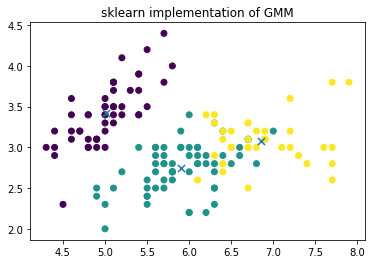

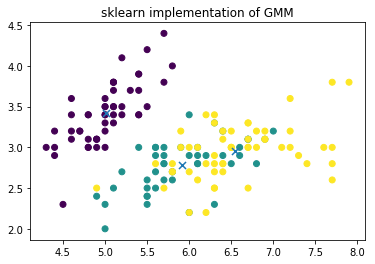

In [8]:
import sklearn.mixture
import sklearn.cluster

kmeans_model = sklearn.cluster.KMeans(3)
kmeans_model.fit(data)
plt.scatter(data[:, 0], data[:, 1], c=kmeans_model.predict(data))
plt.scatter(kmeans_model.cluster_centers_[:, 0], kmeans_model.cluster_centers_[:, 1], s=50, marker='x')
plt.title('sklearn implementation of GMM')
plt.show()

gmm_model = sklearn.mixture.GaussianMixture(3)
gmm_model.fit(data)
plt.scatter(data[:, 0], data[:, 1], c=gmm_model.predict(data))
plt.scatter(gmm_model.means_[:, 0], gmm_model.means_[:, 1], s=50, marker='x')
plt.title('sklearn implementation of GMM')
plt.show()   